IMPORTS

In [2]:
%matplotlib inline  
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

from smt.applications import EGO

import matplotlib.font_manager

import warnings
warnings.filterwarnings("ignore")

import six
import numpy as np
from sklearn.metrics import mean_squared_error

from types import FunctionType

from scipy.stats import norm
from scipy.optimize import minimize

from smt.utils.options_dictionary import OptionsDictionary
from smt.applications.application import SurrogateBasedApplication
from smt.utils.misc import compute_rms_error

from smt.surrogate_models import KPLS, KRG, KPLSK
from smt.sampling_methods import LHS
from  case_generator2 import _import_case

In [3]:


def optim_surrogate( x_data, y_data,vartype,tunnel):
    gpr = KRG(print_global=False)
    gpr.set_training_values(x_data, y_data)
    gpr.train()
    bounds=xlimits
    sampling=LHS(xlimits=xlimits, criterion="ese")
    def SBO( point,vartype=None):
        res = gpr.predict_values(point,vartype)
        return res
    obj_k = lambda x: SBO(np.atleast_2d(x), vartype)
    
    n_start=150
    n_max_optim=40   
    success = False
    n_optim = 1  # in order to have some success optimizations with SLSQP
    while not success and n_optim <= n_max_optim:
        opt_all = []
        x_start = sampling(n_start)
        for ii in range(n_start):
            opt_all.append(minimize(obj_k,x_start[ii, :],method="SLSQP",bounds=bounds,options={"maxiter": 200}))
        opt_all = np.asarray(opt_all)
        opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
        obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
        success = obj_success.size != 0
        if not success:
            self.log("New start point for the internal optimization")
            n_optim += 1

    if n_optim >= n_max_optim:
        # self.log("Internal optimization failed at EGO iter = {}".format(k))
        return np.atleast_2d(0), False
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = np.atleast_2d(opt["x"])
    y_approx= opt["fun"]
    gpr._project_values(x_et_k,vartype)
    y_real=f(x_et_k)
    return y_real,y_approx;

In [4]:
suffix_xdoe = '_xdoe.npy'
suffix_ydoe = '_ydoe.npy'
suffix_xval = '_xval.npy'
suffix_yvaltrue = '_yvaltrue.npy'
suffix_yvalest = '_yvalestimated.npy'

In [5]:
namefun=['Branin_5','Set_1','Set_2','Wong1','Branin_1','Branin_2','Goldstein_1','Cos_1','Spiral','EVD52','Rosen-Suzuki']


30
50
100
200
300
exception :  112-th leading minor of the array is not positive definite
exception :  191-th leading minor of the array is not positive definite


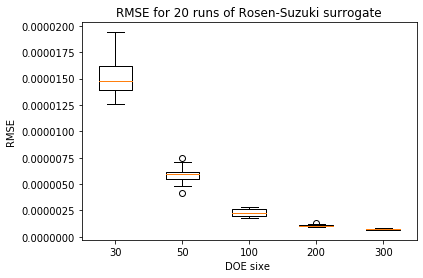

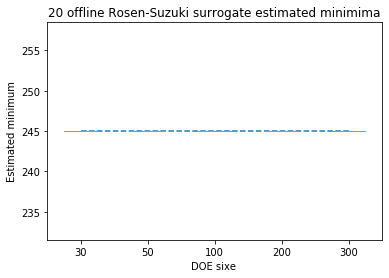

In [6]:
for base_save in namefun:
    dir_name='./results/'+base_save+"/"
    case=_import_case(base_save)()
    sol = case['sol']['value']
    xlimits = case['vars']['bounds']
    vartype=case['vars']['vartype']
    f=case['f_obj']


    nb_doe=20
    RMSE=np.zeros((5,nb_doe))
    SBO_r=np.zeros((5,nb_doe))
    ind=0

    for DOE in [30,50,100,200,300]:
        n_doe=DOE
        print(DOE)
        for k in range(nb_doe) :
            filename= os.path.join(dir_name, base_save+"_"+  str(k)  +"_modval_DOE" +str(DOE)+suffix_yvaltrue)
            yvaltrue=np.load(filename)
            filename= os.path.join(dir_name, base_save+"_"+  str(k)  +"_modval_DOE" +str(DOE)+suffix_yvalest)
            yvaltest=np.load(filename)
            filename= os.path.join(dir_name, base_save+"_" + str(k) +"_modval_DOE" +str(DOE)+ suffix_xdoe)
            x_doe=np.load(filename) 
            filename= os.path.join(dir_name, base_save+"_"+  str(k)  +"_modval_DOE" +str(DOE)+ suffix_ydoe)
            y_doe=np.load(filename) 
            RMSE[ind,k]=mean_squared_error(yvaltrue ,yvaltest,squared=False)
            sbo_i=optim_surrogate(x_data=x_doe, y_data=y_doe,vartype=vartype,tunnel=0)   
            SBO_r[ind,k]=(sbo_i[0])
        ind= ind+1       


    plt.figure()
    plt.boxplot(RMSE.T, labels=["30","50","100","200","300"])
    plt.title("RMSE for {ndoe} runs of {func} surrogate".format(func=base_save,ndoe=nb_doe), loc='center')

    plt.ylabel("RMSE ")
    plt.xlabel("DOE sixe ")

    plt.savefig("./results/"+base_save+"/RMSE",dpi=300,quality=99)
    plt.show()
    nb_pt_plot=100

    cst= np.linspace(sol,sol, nb_pt_plot)

    plt.figure()
    plt.boxplot(SBO_r.T, labels=["30","50","100","200","300"])
    plt.title("{ndoe} offline {func} surrogate estimated minimima".format(func=base_save,ndoe=nb_doe), loc='center')
    plt.plot(np.linspace(1,5,nb_pt_plot),cst, linestyle='--')
    plt.ylabel("Estimated minimum")
    plt.xlabel("DOE sixe ")
    plt.savefig("./results/"+base_save+"/surogate minima ",dpi=300,quality=99)
    plt.show()